# Data Prep / Setup

In [2]:
!pip install plotnine
!pip install xgboost

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import pandas as pd
import numpy as np
import collections
import plotnine
from plotnine import *
import os
import ast
import random
import statsmodels.api as statsm
import pylab as py
import pickle

In [4]:
op10_filtered_path = "./data/OP-10-no-backfill.csv"
op10_dataset = pd.read_csv(op10_filtered_path)
op10_dataset = op10_dataset.dropna(subset = ['lag1'])
op10_dataset['y_quarter'] = op10_dataset['year'].astype(str) + 'Q' + op10_dataset['quarter'].astype(str)
op10_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,10001,6.5,4.6,NaN,2014,2,1.9,4.600000,1.900000,2014Q2
2,10001,6.4,6.5,4.6,2015,2,-0.1,5.550000,0.850000,2015Q2
3,10001,9.0,6.4,6.5,2016,2,2.6,5.833333,3.166667,2016Q2
4,10001,6.5,9.0,6.4,2017,2,-2.5,6.625000,-0.125000,2017Q2
5,10001,8.0,6.5,9.0,2018,2,1.5,6.600000,1.400000,2018Q2
...,...,...,...,...,...,...,...,...,...,...
29089,670120,7.5,6.6,1.7,2019,2,0.9,4.150000,3.350000,2019Q2
29090,670120,1.6,7.5,6.6,2019,4,-5.9,5.266667,-3.666667,2019Q4
29092,670122,12.6,16.1,NaN,2019,2,-3.5,16.100000,-3.500000,2019Q2
29093,670122,8.7,12.6,16.1,2019,4,-3.9,14.350000,-5.650000,2019Q4


In [5]:
op10_dataset.describe()

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff
count,24799.000000,24799.000000,24799.000000,20675.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000
mean,263954.500867,7.413763,8.661273,8.976958,2016.850034,2.250413,-1.247510,9.732317,-2.318554
std,154103.572163,8.414690,9.470437,9.815834,1.798227,0.661920,4.511939,10.353490,6.122558
min,10001.000000,0.100000,0.100000,0.100000,2014.000000,2.000000,-75.400000,0.100000,-75.400000
25%,140125.000000,2.700000,3.400000,3.500000,2015.000000,2.000000,-2.500000,3.780000,-3.500000
50%,250102.000000,5.100000,5.900000,6.000000,2017.000000,2.000000,-0.500000,6.300000,-1.000000
75%,390058.000000,8.800000,10.000000,10.300000,2019.000000,2.000000,0.800000,11.250000,0.550000
max,670128.000000,92.000000,96.400000,96.400000,2019.000000,4.000000,44.600000,96.400000,44.600000


In [6]:
op10_dataset.query('y_quarter != "2019Q4"').describe()

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff
count,21694.000000,21694.000000,21694.000000,17592.000000,21694.000000,21694.0,21694.000000,21694.000000,21694.000000
mean,263766.336775,8.159450,8.927086,9.267764,2016.542316,2.0,-0.767636,9.901452,-1.742003
std,154204.871226,8.708054,9.883479,10.301275,1.714686,0.0,4.362832,10.711228,5.863599
min,10001.000000,0.100000,0.100000,0.100000,2014.000000,2.0,-75.400000,0.100000,-75.400000
25%,140122.000000,3.300000,3.400000,3.500000,2015.000000,2.0,-1.800000,3.720000,-2.633333
50%,250097.000000,5.700000,5.900000,6.100000,2017.000000,2.0,-0.200000,6.300000,-0.600000
75%,390057.000000,9.500000,10.300000,10.700000,2018.000000,2.0,1.000000,11.400000,0.800000
max,670122.000000,92.000000,96.400000,96.400000,2019.000000,2.0,44.600000,96.400000,44.600000


In [7]:
xgbr_model_path = './xgboost-regression/xgbr_model_final.pkl'
iforest_model_path = './isolation-forest/iforest_model_final.pkl'
ensemble_model_path = './xgbr-ensemble/ensemble_model_final.pkl'
ensemble_model_final = pickle.load(open(ensemble_model_path, 'rb'))

In [8]:
def load_and_predict_xgbr(model_file, modeling_dataset, target, threshold):
    xgbr_model = pickle.load(open(model_file, 'rb'))
    scores = xgbr_model.predict(modeling_dataset)
    prediction = abs(target - scores) > threshold
    
    return scores, prediction

In [9]:
def load_and_predict_iforest(model_file, modeling_dataset, threshold): 
    if_model = pickle.load(open(model_file, 'rb'))
    scores = if_model.score_samples(modeling_dataset) * -1
    prediction = scores > threshold

    return scores, prediction

In [10]:
xgbr_scores, xgbr_prediction =\
    load_and_predict_xgbr(xgbr_model_path,
                          op10_dataset[['lag1','prov_mean']],
                          op10_dataset['score'],
                          4)

In [11]:
iforest_scores, iforest_prediction =\
    load_and_predict_iforest(iforest_model_path,
                          op10_dataset[['lag_diff','prov_mean_diff']],
                          .5)

In [12]:
xgb_op10_dataset = op10_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgb_op10_dataset['outlier'] = xgbr_prediction
xgb_op10_dataset['model_score'] = xgbr_scores
xgb_op10_dataset['model'] = "XGBoost Regression"
xgb_op10_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,6.5,2014Q2,10001,4.600000,1.9,1.900000,False,4.753499,XGBoost Regression
2,6.4,2015Q2,10001,5.550000,-0.1,0.850000,False,5.982095,XGBoost Regression
3,9.0,2016Q2,10001,5.833333,2.6,3.166667,False,6.174885,XGBoost Regression
4,6.5,2017Q2,10001,6.625000,-2.5,-0.125000,False,7.982599,XGBoost Regression
5,8.0,2018Q2,10001,6.600000,1.5,1.400000,False,6.406641,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
29089,7.5,2019Q2,670120,4.150000,0.9,3.350000,False,6.062563,XGBoost Regression
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,True,6.798064,XGBoost Regression
29092,12.6,2019Q2,670122,16.100000,-3.5,-3.500000,False,14.525786,XGBoost Regression
29093,8.7,2019Q4,670122,14.350000,-3.9,-5.650000,False,11.732296,XGBoost Regression


In [13]:
if_op10_dataset = op10_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_op10_dataset['outlier'] = iforest_prediction
if_op10_dataset['model_score'] = iforest_scores
if_op10_dataset['model'] = "Isolation Forest"
if_op10_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,6.5,2014Q2,10001,4.600000,1.9,1.900000,False,0.443219,Isolation Forest
2,6.4,2015Q2,10001,5.550000,-0.1,0.850000,False,0.387362,Isolation Forest
3,9.0,2016Q2,10001,5.833333,2.6,3.166667,False,0.470720,Isolation Forest
4,6.5,2017Q2,10001,6.625000,-2.5,-0.125000,False,0.401492,Isolation Forest
5,8.0,2018Q2,10001,6.600000,1.5,1.400000,False,0.422357,Isolation Forest
...,...,...,...,...,...,...,...,...,...
29089,7.5,2019Q2,670120,4.150000,0.9,3.350000,False,0.444184,Isolation Forest
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,False,0.469713,Isolation Forest
29092,12.6,2019Q2,670122,16.100000,-3.5,-3.500000,False,0.434941,Isolation Forest
29093,8.7,2019Q4,670122,14.350000,-3.9,-5.650000,False,0.458783,Isolation Forest


In [14]:
ensemble_dataset = op10_dataset[['lag1','prov_mean','score']].copy()
ensemble_dataset['iforest_scores'] = iforest_scores
ensemble_dataset

,lag1,prov_mean,score,iforest_scores
1,4.6,4.600000,6.5,0.443219
2,6.5,5.550000,6.4,0.387362
3,6.4,5.833333,9.0,0.470720
4,9.0,6.625000,6.5,0.401492
5,6.5,6.600000,8.0,0.422357
...,...,...,...,...
29089,6.6,4.150000,7.5,0.444184
29090,7.5,5.266667,1.6,0.469713
29092,16.1,16.100000,12.6,0.434941
29093,12.6,14.350000,8.7,0.458783


In [15]:
ensemble_dataset[['iforest_scores', 'lag1','prov_mean']]

,iforest_scores,lag1,prov_mean
1,0.443219,4.6,4.600000
2,0.387362,6.5,5.550000
3,0.470720,6.4,5.833333
4,0.401492,9.0,6.625000
5,0.422357,6.5,6.600000
...,...,...,...
29089,0.444184,6.6,4.150000
29090,0.469713,7.5,5.266667
29092,0.434941,16.1,16.100000
29093,0.458783,12.6,14.350000


In [16]:
ensemble_scores, ensemble_prediction =\
    load_and_predict_xgbr(ensemble_model_path,
                          ensemble_dataset[['iforest_scores','lag1','prov_mean']],
                          ensemble_dataset['score'],
                          3)

In [17]:
ensemble_op10_dataset = op10_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_op10_dataset['outlier'] = ensemble_prediction
ensemble_op10_dataset['model_score'] = ensemble_scores
ensemble_op10_dataset['model'] = "Ensemble Model"
ensemble_op10_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,6.5,2014Q2,10001,4.600000,1.9,1.900000,False,5.738575,Ensemble Model
2,6.4,2015Q2,10001,5.550000,-0.1,0.850000,False,5.301938,Ensemble Model
3,9.0,2016Q2,10001,5.833333,2.6,3.166667,False,6.597307,Ensemble Model
4,6.5,2017Q2,10001,6.625000,-2.5,-0.125000,False,7.151802,Ensemble Model
5,8.0,2018Q2,10001,6.600000,1.5,1.400000,False,5.742346,Ensemble Model
...,...,...,...,...,...,...,...,...,...
29089,7.5,2019Q2,670120,4.150000,0.9,3.350000,False,5.756759,Ensemble Model
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,True,6.280502,Ensemble Model
29092,12.6,2019Q2,670122,16.100000,-3.5,-3.500000,False,14.185899,Ensemble Model
29093,8.7,2019Q4,670122,14.350000,-3.9,-5.650000,False,11.234047,Ensemble Model


In [18]:
comparison_df = pd.concat([xgb_op10_dataset, if_op10_dataset, ensemble_op10_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,6.5,2014Q2,10001,4.600000,1.9,1.900000,False,4.753499,XGBoost Regression
2,6.4,2015Q2,10001,5.550000,-0.1,0.850000,False,5.982095,XGBoost Regression
3,9.0,2016Q2,10001,5.833333,2.6,3.166667,False,6.174885,XGBoost Regression
4,6.5,2017Q2,10001,6.625000,-2.5,-0.125000,False,7.982599,XGBoost Regression
5,8.0,2018Q2,10001,6.600000,1.5,1.400000,False,6.406641,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
29089,7.5,2019Q2,670120,4.150000,0.9,3.350000,False,5.756759,Ensemble Model
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,True,6.280502,Ensemble Model
29092,12.6,2019Q2,670122,16.100000,-3.5,-3.500000,False,14.185899,Ensemble Model
29093,8.7,2019Q4,670122,14.350000,-3.9,-5.650000,False,11.234047,Ensemble Model


# XGBoost Regression Model
#### RMSE (lower is better)
During the tuning process, the cross-validated RMSE was 5.86 (5-fold, 10 repetitions)

#### Threshold Testing and Performance (higher is better)
A threshold of 3 performs best in the artifical anomaly test, with an AUROC of 0.841. A threshold of 4 was selected as this makes model is more conservative and affects the AUROC marginally with a score of 0.832


# Isolation Forest Model
##### Threshold Test and Performance (higher is better)
A threshold of .5 performs best in the artifical anomaly test, with an AUROC of 0.773


# XGBoost Ensemble Model
#### RMSE (lower is better)
During the tuning process, the cross-validated RMSE was 2.77 (5-fold, 10 repetitions)
#### Threshold Test and Performance (higher is better)
A threshold of .3 performs best in the artifical anomaly test, with an AUROC of 0.914

# Performance Comparison
The XGBoost Ensemble model performs best, both in cross-validated RMSE and the artificial anomaly test AUROC 

||XGBoost Regression|Isolation Forest|XGBoost Ensemble|
|---|---|---|---|
|CV RMSE|5.86|N/A|2.77|
|AUROC|0.832|0.773|0.914|



# Model Comparisons
The distribution of predicted outliers was rather consistent across all three models, with the ensemble model having a slightly lower mean. For 2019Q4, the ensemble model identified the highest proporition of anomalies out of the three (60%). 

In [19]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  20538.0          21096.0        20827.0   
      mean                       6.4              6.4            7.1   
      std                        6.6              6.9            7.5   
      min                        0.1              0.1            0.1   
      10%                        1.3              1.2            1.5   
      25%                        2.7              2.5            3.0   
      50%                        4.9              4.7            5.2   
      75%                        7.9              7.7            8.5   
      90%                       12.4             12.4           14.0   
      max                       82.9             92.0           82.7   

Predicted Outlier               True                                  
Model             XGBoost Regression Isolation Forest Ensemble Model  
Score count                   4261.0           3703.0         3972.0  
      mean                      12.2             13.5            8.9  
      std                       13.3             12.7           12.1  
      min                        0.2              0.2            0.2  
      10%                        1.3              2.1            0.9  
      25%                        2.5              4.4            1.6  
      50%                        7.7              9.9            3.3  
      75%                       17.0             17.5           12.5  
      90%                       30.2             30.3           23.0  
      max                       92.0             82.9           92.0

#### XGBoost Outlier Counts by Quarter

In [20]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,621,3531,17.59
2015Q2,540,3527,15.31
2016Q2,470,3560,13.20
2017Q2,452,3598,12.56
2018Q2,370,3678,10.06
2019Q2,377,3800,9.92
2019Q4,1431,3105,46.09


#### Isolation Forest Outlier Counts by Quarter

In [21]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,501,3531,14.19
2015Q2,502,3527,14.23
2016Q2,474,3560,13.31
2017Q2,497,3598,13.81
2018Q2,460,3678,12.51
2019Q2,403,3800,10.61
2019Q4,866,3105,27.89


#### Ensemble Model Outlier Counts by Quarter

In [22]:
ensemble = comparison_df.query('model == "Ensemble Model"')

summary_table = pd.DataFrame({"outlier count": ensemble.loc[ ensemble['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": ensemble['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,395,3531,11.19
2015Q2,379,3527,10.75
2016Q2,351,3560,9.86
2017Q2,340,3598,9.45
2018Q2,312,3678,8.48
2019Q2,329,3800,8.66
2019Q4,1866,3105,60.10


In [23]:
outlier_comparison = comparison_df.query('model == "Ensemble Model"')[['outlier', 'lag_diff', 'prov_mean_diff']].copy()
outlier_comparison[['lag_diff', 'prov_mean_diff']] = abs(outlier_comparison[['lag_diff', 'prov_mean_diff']])
outlier_comparison = outlier_comparison.rename(columns = {'lag_diff':'Difference from Previous Score',
                                                          'prov_mean_diff': 'Difference from Provider Mean Score',
                                                          'outlier': 'Predicted Anomaly'})
outlier_comparison.groupby('Predicted Anomaly').describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).loc[:,(slice(None),['mean','std','1%', '10%', '25%', '50%', '75%','90%','99%'])].transpose()


Predicted Anomaly                             False       True
Difference from Previous Score      mean   2.102213   6.090282
                                    std    3.210412   4.744948
                                    1%     0.000000   1.100000
                                    10%    0.200000   2.400000
                                    25%    0.500000   3.300000
                                    50%    1.300000   4.800000
                                    75%    2.400000   7.300000
                                    90%    4.400000  11.000000
                                    99%   15.774000  25.587000
Difference from Provider Mean Score mean   3.007589   7.257000
                                    std    4.916668   6.384566
                                    1%     0.016667   0.433333
                                    10%    0.250000   2.200000
                                    25%    0.650000   3.481250
                                    50%    1.533333   5.260000
                                    75%    3.100000   8.667857
                                    90%    6.768571  14.570000
                                    99%   26.665333  31.964500

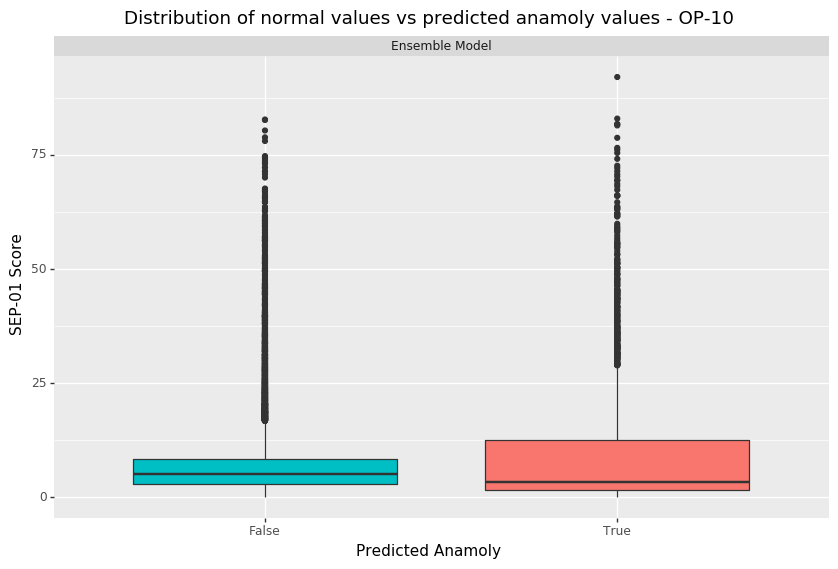

<ggplot: (8758843517501)>

In [24]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values - OP-10")
 + ylab("SEP-01 Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model')
)

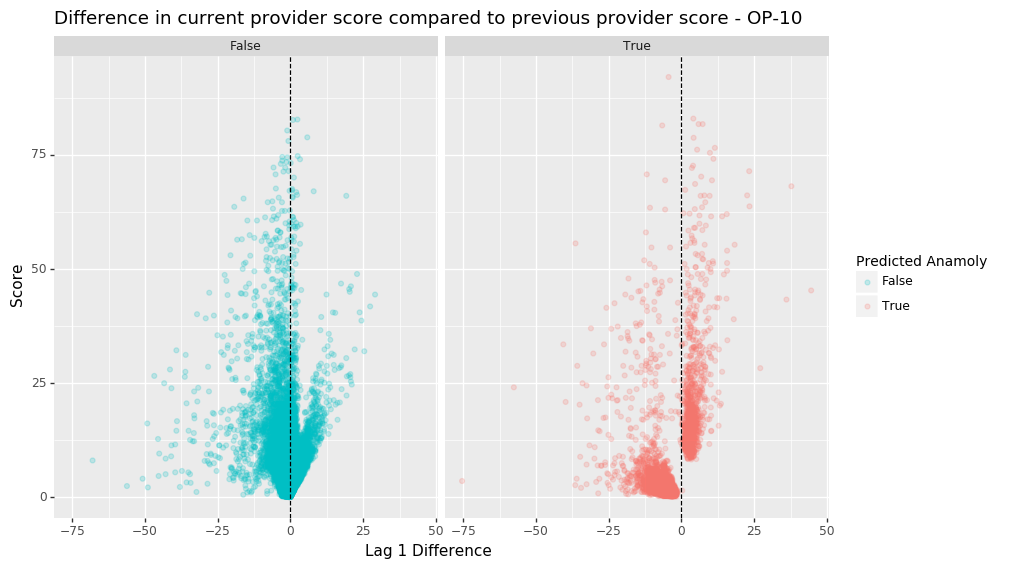

<ggplot: (8758837049493)>

In [25]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - OP-10")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

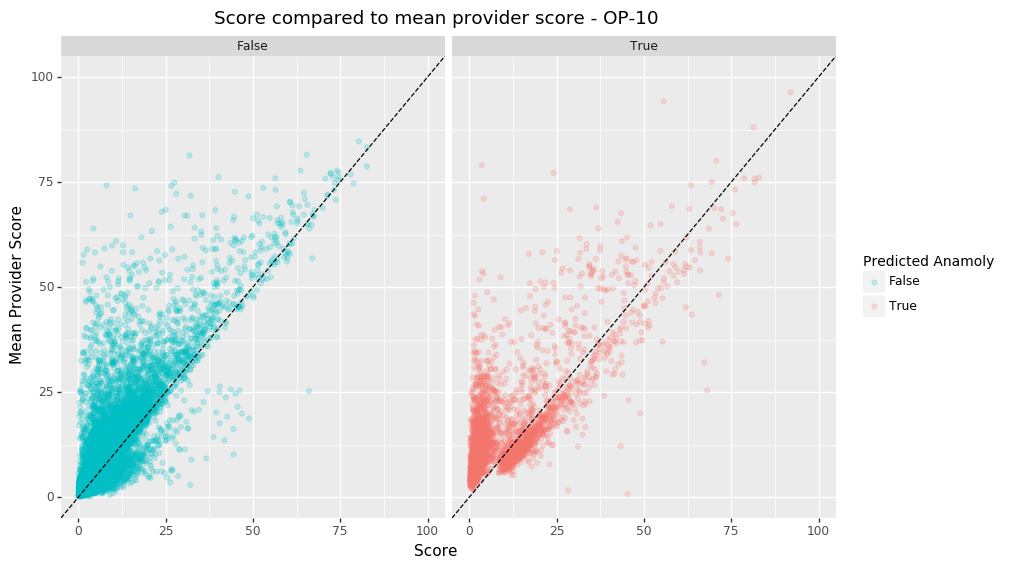

<ggplot: (8758836976745)>

In [26]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score - OP-10")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

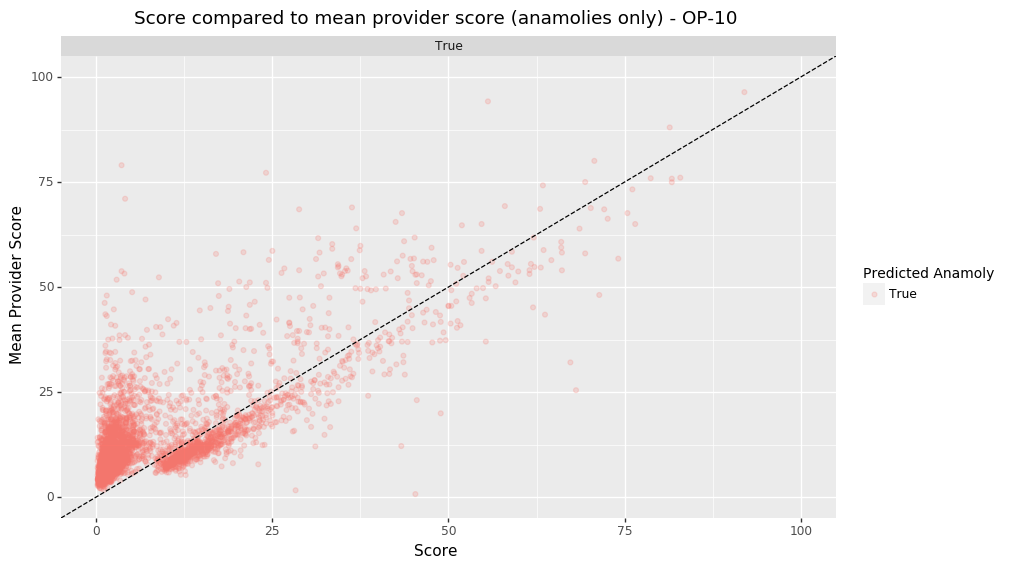

<ggplot: (8758836851357)>

In [27]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model" and outlier == True'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only) - OP-10")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

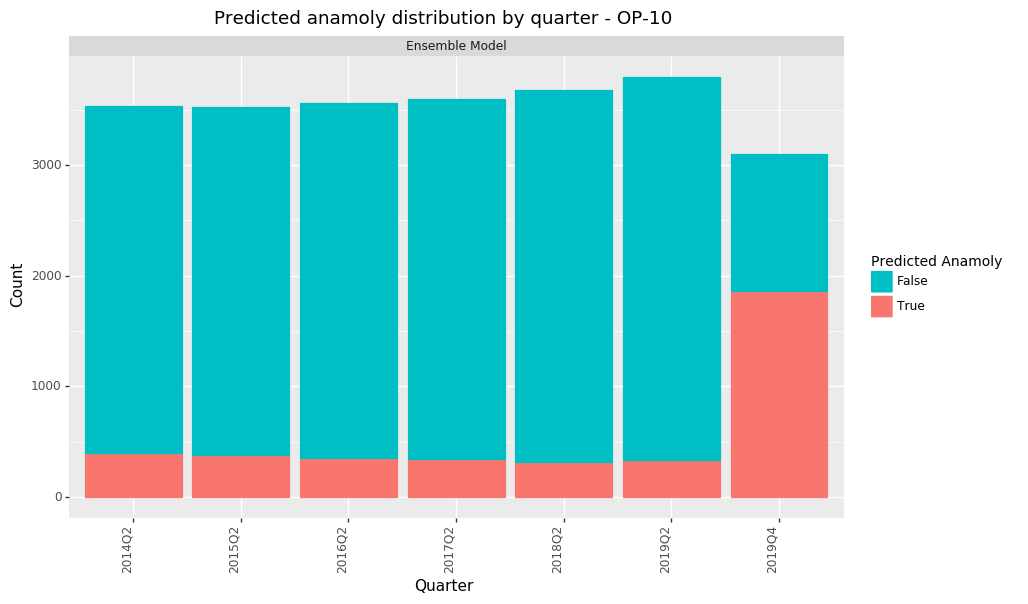

<ggplot: (8758843515977)>

In [28]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter - OP-10")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

# 2019Q4 Comparison

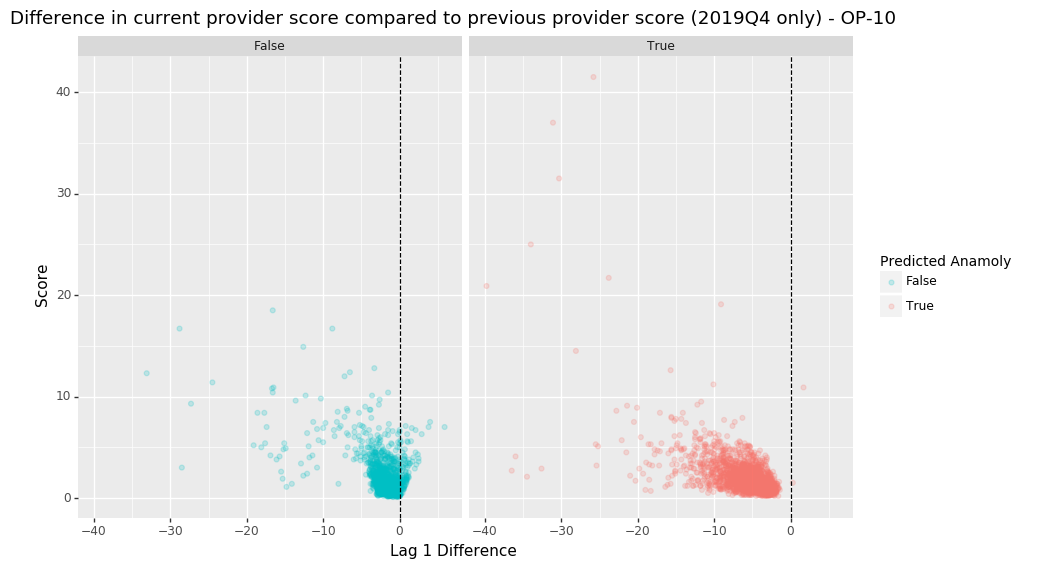

<ggplot: (8758923198509)>

In [29]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"').query('y_quarter == "2019Q4"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score (2019Q4 only) - OP-10")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


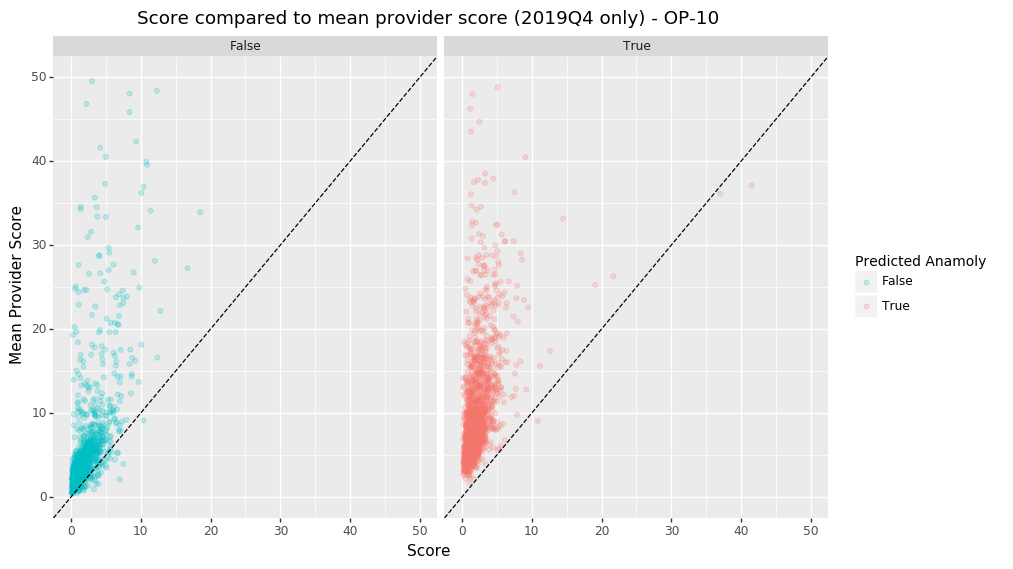

<ggplot: (8758828047857)>

In [30]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"').query('y_quarter == "2019Q4"'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (2019Q4 only) - OP-10")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,50)
 + ylim(0,50)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

# Ensemble Model 2019 Q4 Results
At a glance, the ensemble model only identifying 60% of the 2019Q4 data as anomalies seems rather low. However, the vast majority of these providers showed very little change when compared to the provider's last value and the provider's historical mean score, as shown below. In any model, it would be near impossible to identify these sorts of outliers. That being said, the large jump in proportion of predicted outliers for 2019Q4 (correctly) signals that there are major issues with the data for that quarter. 

##### Summary Statistics of 2019Q4 Providers not labeled as outliers by the Ensemble Model:

In [31]:
ensemble_2019q4_dataset = comparison_df.copy().query('model == "Ensemble Model"')
ensemble_2019q4_dataset['iforest_scores'] = iforest_scores
ensemble_2019q4_dataset = ensemble_2019q4_dataset.query('y_quarter == "2019Q4"')
non_outlier_providers = ensemble_2019q4_dataset.query('outlier == False')['provider_id']

In [32]:
non_outlier_df = ensemble_op10_dataset[ensemble_op10_dataset['provider_id'].isin(non_outlier_providers)]
non_outlier_df = non_outlier_df.rename(columns = {'score':'Score',
                                                  'prov_mean_diff': 'Provider Mean Difference',
                                                  'lag_diff': 'Lag Difference'})
non_outlier_df[['Score','Lag Difference','Provider Mean Difference']]\
    .describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])\
    .drop(['count'])\
    .round(2)

,Score,Lag Difference,Provider Mean Difference
mean,5.24,-0.89,-1.85
std,7.02,3.63,5.28
min,0.10,-75.40,-75.40
1%,0.30,-14.91,-27.05
5%,0.60,-5.60,-10.56
10%,1.00,-3.50,-5.45
25%,2.00,-1.70,-2.33
50%,3.40,-0.40,-0.70
75%,5.50,0.60,0.38
90%,9.80,1.80,1.60


In [33]:
abs(non_outlier_df['Lag Difference'])\
    .describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])\
    .drop(['count'])\
    .round(2)

mean     1.99
std      3.17
min      0.00
1%       0.00
10%      0.20
25%      0.50
50%      1.20
75%      2.30
90%      4.10
99%     15.01
max     75.40
Name: Lag Difference, dtype: float64

In [34]:
abs(non_outlier_df['Provider Mean Difference'])\
    .describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])\
    .drop(['count'])\
    .round(2)

mean     2.77
std      4.86
min      0.00
1%       0.02
10%      0.20
25%      0.56
50%      1.35
75%      2.76
90%      5.94
99%     27.05
max     75.40
Name: Provider Mean Difference, dtype: float64

##### Provider Examples:

In [35]:
ensemble_op10_dataset
i = 0
provider_dfs = []
for p in non_outlier_providers:
    df = ensemble_op10_dataset[ensemble_op10_dataset['provider_id'] == p]
    provider_dfs.append(df)
    i +=1

total = ensemble_2019q4_dataset['provider_id'].nunique()
print("Total Providers in 2019Q4 labeled as non-outliers: " + str(i) + "/" + str(total))
for p in provider_dfs[1:5]:
    display(p)

Total Providers in 2019Q4 labeled as non-outliers: 1239/3105


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
41,4.9,2014Q2,10011,6.200000,-1.3,-1.300000,False,5.476944,Ensemble Model
42,2.4,2015Q2,10011,5.550000,-2.5,-3.150000,False,4.559717,Ensemble Model
43,4.8,2016Q2,10011,4.500000,2.4,0.300000,False,3.542201,Ensemble Model
44,3.1,2017Q2,10011,4.575000,-1.7,-1.475000,False,4.210943,Ensemble Model
45,4.6,2018Q2,10011,4.280000,1.5,0.320000,False,3.426484,Ensemble Model
46,5.3,2019Q2,10011,4.333333,0.7,0.966667,False,4.109367,Ensemble Model
47,3.2,2019Q4,10011,4.471429,-2.1,-1.271429,False,4.614377,Ensemble Model


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
95,11.1,2014Q2,10024,12.600000,-1.5,-1.500000,False,12.003718,Ensemble Model
96,9.1,2015Q2,10024,11.850000,-2.0,-2.750000,False,10.403178,Ensemble Model
97,18.2,2016Q2,10024,10.933333,9.1,7.266667,False,18.955950,Ensemble Model
98,12.5,2017Q2,10024,12.750000,-5.7,-0.250000,False,14.217822,Ensemble Model
99,1.9,2018Q2,10024,12.700000,-10.6,-10.800000,True,9.323521,Ensemble Model
100,1.3,2019Q2,10024,10.900000,-0.6,-9.600000,False,2.884537,Ensemble Model
101,1.1,2019Q4,10024,9.528571,-0.2,-8.428571,False,3.003429,Ensemble Model


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
180,1.3,2014Q2,10045,1.700000,-0.4,-0.400000,False,1.541743,Ensemble Model
181,1.6,2015Q2,10045,1.500000,0.3,0.100000,False,1.049778,Ensemble Model
182,2.3,2016Q2,10045,1.533333,0.7,0.766667,False,1.908816,Ensemble Model
183,3.8,2017Q2,10045,1.725000,1.5,2.075000,False,3.902022,Ensemble Model
184,2.9,2018Q2,10045,2.140000,-0.9,0.760000,False,2.581907,Ensemble Model
185,3.5,2019Q2,10045,2.266667,0.6,1.233333,False,2.881119,Ensemble Model
186,1.6,2019Q4,10045,2.442857,-1.9,-0.842857,False,2.796205,Ensemble Model


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
188,3.6,2014Q2,10046,7.400000,-3.8,-3.800000,False,6.466862,Ensemble Model
189,2.1,2015Q2,10046,5.500000,-1.5,-3.400000,False,3.947278,Ensemble Model
190,4.0,2016Q2,10046,4.366667,1.9,-0.366667,False,3.120723,Ensemble Model
191,3.6,2017Q2,10046,4.275000,-0.4,-0.675000,False,3.651859,Ensemble Model
192,6.9,2018Q2,10046,4.140000,3.3,2.760000,False,6.586184,Ensemble Model
193,4.2,2019Q2,10046,4.600000,-2.7,-0.400000,False,5.234828,Ensemble Model
194,1.7,2019Q4,10046,4.542857,-2.5,-2.842857,False,4.223978,Ensemble Model


In [36]:
ensemble_op10_dataset
i = 0
provider_dfs = []
for p in non_outlier_providers:
    df = ensemble_op10_dataset[ensemble_op10_dataset['provider_id'] == p]
    if sum(df['outlier'].values) > 0:
        provider_dfs.append(df)
        i +=1

total = ensemble_2019q4_dataset['provider_id'].nunique()
print("Total Providers in 2019Q4 labeled as non-outliers with a past outlier: " + str(i) + "/" + str(total))
for p in provider_dfs[1:5]:
    display(p)

Total Providers in 2019Q4 labeled as non-outliers with a past outlier: 308/3105


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
254,51.2,2014Q2,10062,40.300000,10.9,10.900000,True,40.317509,Ensemble Model
255,33.3,2015Q2,10062,45.750000,-17.9,-12.450000,False,35.281601,Ensemble Model
256,28.3,2016Q2,10062,41.600000,-5.0,-13.300000,False,28.894064,Ensemble Model
257,32.9,2017Q2,10062,38.275000,4.6,-5.375000,True,26.524448,Ensemble Model
258,27.7,2018Q2,10062,37.200000,-5.2,-9.500000,False,29.726448,Ensemble Model
259,19.9,2019Q2,10062,35.616667,-7.8,-15.716667,False,21.927486,Ensemble Model
260,3.8,2019Q4,10062,33.371429,-16.1,-29.571429,False,6.311305,Ensemble Model


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
293,22.2,2014Q2,10079,24.200000,-2.0,-2.000000,False,23.028051,Ensemble Model
294,26.6,2015Q2,10079,23.200000,4.4,3.400000,True,18.622900,Ensemble Model
295,27.2,2016Q2,10079,24.333333,0.6,2.866667,True,23.330050,Ensemble Model
296,21.4,2017Q2,10079,25.050000,-5.8,-3.650000,False,23.344091,Ensemble Model
297,10.3,2018Q2,10079,24.320000,-11.1,-14.020000,True,14.006248,Ensemble Model
298,5.7,2019Q2,10079,21.983333,-4.6,-16.283333,False,8.328962,Ensemble Model
299,5.5,2019Q4,10079,19.657143,-0.2,-14.157143,False,5.741959,Ensemble Model


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
443,12.9,2014Q2,10112,19.600000,-6.7,-6.700000,False,13.777014,Ensemble Model
444,11.8,2015Q2,10112,16.250000,-1.1,-4.450000,False,12.843018,Ensemble Model
445,10.1,2016Q2,10112,14.766667,-1.7,-4.666667,False,11.498241,Ensemble Model
446,7.2,2017Q2,10112,13.600000,-2.9,-6.400000,False,8.906343,Ensemble Model
447,3.2,2018Q2,10112,12.320000,-4.0,-9.120000,True,6.664589,Ensemble Model
448,3.7,2019Q2,10112,10.800000,0.5,-7.100000,False,4.436730,Ensemble Model
449,2.3,2019Q4,10112,9.785714,-1.4,-7.485714,False,4.758605,Ensemble Model


,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
496,35.6,2014Q2,10128,39.100000,-3.5,-3.500000,False,36.618259,Ensemble Model
497,29.6,2015Q2,10128,37.350000,-6.0,-7.750000,False,32.544888,Ensemble Model
498,18.0,2016Q2,10128,34.766667,-11.6,-16.766667,False,19.899549,Ensemble Model
499,10.2,2017Q2,10128,30.575000,-7.8,-20.375000,False,11.049816,Ensemble Model
500,23.0,2018Q2,10128,26.500000,12.8,-3.500000,True,11.685369,Ensemble Model
501,17.2,2019Q2,10128,25.916667,-5.8,-8.716667,False,18.221952,Ensemble Model
502,1.9,2019Q4,10128,24.671429,-15.3,-22.771429,False,4.604200,Ensemble Model


In [37]:
ensemble_op10_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,6.5,2014Q2,10001,4.600000,1.9,1.900000,False,5.738575,Ensemble Model
2,6.4,2015Q2,10001,5.550000,-0.1,0.850000,False,5.301938,Ensemble Model
3,9.0,2016Q2,10001,5.833333,2.6,3.166667,False,6.597307,Ensemble Model
4,6.5,2017Q2,10001,6.625000,-2.5,-0.125000,False,7.151802,Ensemble Model
5,8.0,2018Q2,10001,6.600000,1.5,1.400000,False,5.742346,Ensemble Model
...,...,...,...,...,...,...,...,...,...
29089,7.5,2019Q2,670120,4.150000,0.9,3.350000,False,5.756759,Ensemble Model
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,True,6.280502,Ensemble Model
29092,12.6,2019Q2,670122,16.100000,-3.5,-3.500000,False,14.185899,Ensemble Model
29093,8.7,2019Q4,670122,14.350000,-3.9,-5.650000,False,11.234047,Ensemble Model


In [38]:
op10_dataset['provider_id'].nunique()

4124

In [39]:
op10_dataset.query('y_quarter != "2019Q4"').score.describe(percentiles = [.01, .1, .25, .5, .75, .9, .99]).round(1)

count    21694.0
mean         8.2
std          8.7
min          0.1
1%           0.4
10%          1.8
25%          3.3
50%          5.7
75%          9.5
90%         16.5
99%         47.5
max         92.0
Name: score, dtype: float64

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 86'. Pick better value with 'binwidth'.


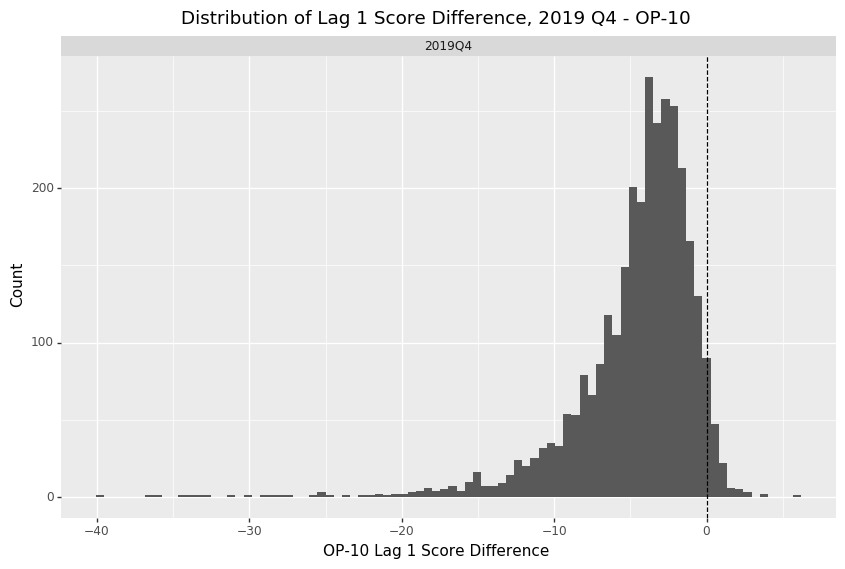

<ggplot: (8758843545113)>

In [40]:
plotnine.options.figure_size = (10,6)
(ggplot(ensemble_op10_dataset.query('y_quarter == "2019Q4"'),     
        aes(x = 'lag_diff'))
 + ggtitle("Distribution of Lag 1 Score Difference, 2019 Q4 - OP-10")
 + xlab("OP-10 Lag 1 Score Difference")
 + ylab("Count")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 #+ scale_color_manual(values = ["#00BFC4", "#F8766D"])
 #+ scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_histogram()
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~y_quarter')
 + theme(legend_title = element_text(size = 10))
)

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 188'. Pick better value with 'binwidth'.


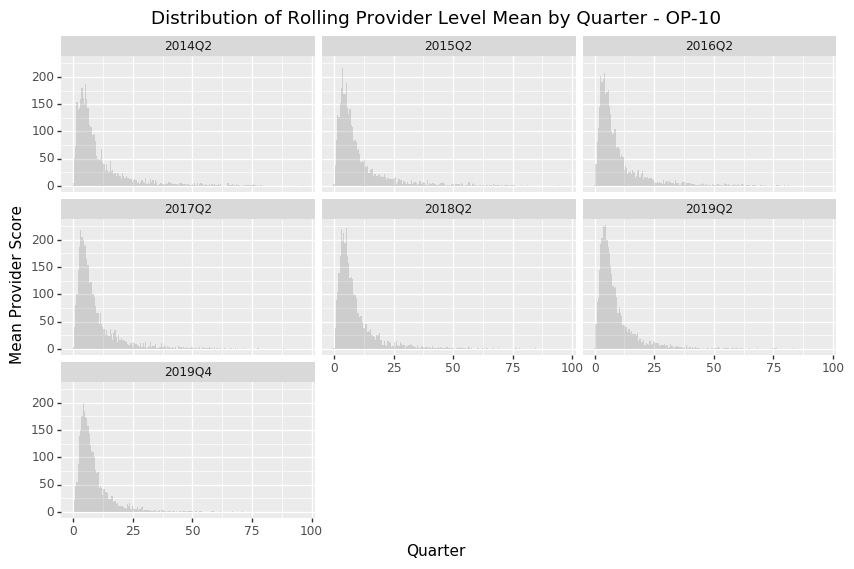

<ggplot: (8758827909381)>

In [41]:
plotnine.options.figure_size = (10,6)
(ggplot(op10_dataset,
        aes(x = 'prov_mean'))
 + ggtitle("Distribution of Rolling Provider Level Mean by Quarter - OP-10")
 + geom_histogram(alpha = 0.2)
 + xlab("Quarter")
 + ylab("Mean Provider Score")
 #+ labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 #+ scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + theme(legend_title = element_text(size = 10))
 + facet_wrap('~y_quarter')
)

In [42]:
large_prov_mean_diff = ensemble_op10_dataset[ensemble_op10_dataset['provider_id']\
    .isin(non_outlier_providers)]\
    .query('y_quarter == "2019Q4"')

In [43]:
large_prov_mean_diff['prov_mean_diff_abs'] = abs(large_prov_mean_diff['prov_mean_diff'])
large_prov_mean_diff['lag_diff_abs'] = abs(large_prov_mean_diff['lag_diff'])

In [44]:
large_prov_mean_diff.query('lag_diff_abs > 4')

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,prov_mean_diff_abs,lag_diff_abs
260,3.8,2019Q4,10062,33.371429,-16.1,-29.571429,False,6.311305,Ensemble Model,29.571429,16.1
502,1.9,2019Q4,10128,24.671429,-15.3,-22.771429,False,4.604200,Ensemble Model,22.771429,15.3
577,7.4,2019Q4,10157,24.585714,-9.7,-17.185714,False,9.765985,Ensemble Model,17.185714,9.7
764,5.5,2019Q4,30013,29.085714,-10.0,-23.585714,False,8.327628,Ensemble Model,23.585714,10.0
1097,3.8,2019Q4,31304,4.250000,-4.6,-0.450000,False,6.105623,Ensemble Model,0.450000,4.6
...,...,...,...,...,...,...,...,...,...,...,...
27564,6.1,2019Q4,510001,10.200000,-5.3,-4.100000,False,8.699607,Ensemble Model,4.100000,5.3
27882,3.0,2019Q4,511321,21.680000,-10.8,-18.680000,False,4.996140,Ensemble Model,18.680000,10.8
28218,3.7,2019Q4,520100,34.514286,-5.1,-30.814286,False,6.661524,Ensemble Model,30.814286,5.1
28345,7.0,2019Q4,520206,13.657143,-5.9,-6.657143,False,9.359195,Ensemble Model,6.657143,5.9


In [45]:
96/3105

0.030917874396135265

In [46]:
ensemble_op10_dataset[abs(ensemble_op10_dataset['lag_diff']) > 4].query('y_quarter == "2019Q4"')

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
7,1.1,2019Q4,10001,6.885714,-6.1,-5.785714,True,6.544734,Ensemble Model
15,5.0,2019Q4,10005,13.671429,-9.2,-8.671429,True,10.981252,Ensemble Model
23,4.4,2019Q4,10006,12.714286,-10.1,-8.314286,True,11.789478,Ensemble Model
31,1.1,2019Q4,10007,19.114286,-8.0,-18.014286,True,9.835993,Ensemble Model
63,5.1,2019Q4,10016,23.728571,-9.0,-18.628571,True,8.887455,Ensemble Model
...,...,...,...,...,...,...,...,...,...
29042,2.9,2019Q4,670088,7.766667,-4.7,-4.866667,True,6.413286,Ensemble Model
29053,12.3,2019Q4,670093,48.360000,-33.1,-36.060000,False,12.534213,Ensemble Model
29062,1.9,2019Q4,670098,6.340000,-7.3,-4.440000,True,7.324170,Ensemble Model
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,True,6.280502,Ensemble Model


In [47]:
1- 96/1397

0.9312813171080887

In [48]:
diff_dataset = ensemble_op10_dataset.copy()
diff_dataset['diff'] =  diff_dataset['score'] - ensemble_op10_dataset['model_score']
diff_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,diff
1,6.5,2014Q2,10001,4.600000,1.9,1.900000,False,5.738575,Ensemble Model,0.761425
2,6.4,2015Q2,10001,5.550000,-0.1,0.850000,False,5.301938,Ensemble Model,1.098062
3,9.0,2016Q2,10001,5.833333,2.6,3.166667,False,6.597307,Ensemble Model,2.402693
4,6.5,2017Q2,10001,6.625000,-2.5,-0.125000,False,7.151802,Ensemble Model,-0.651802
5,8.0,2018Q2,10001,6.600000,1.5,1.400000,False,5.742346,Ensemble Model,2.257654
...,...,...,...,...,...,...,...,...,...,...
29089,7.5,2019Q2,670120,4.150000,0.9,3.350000,False,5.756759,Ensemble Model,1.743241
29090,1.6,2019Q4,670120,5.266667,-5.9,-3.666667,True,6.280502,Ensemble Model,-4.680502
29092,12.6,2019Q2,670122,16.100000,-3.5,-3.500000,False,14.185899,Ensemble Model,-1.585899
29093,8.7,2019Q4,670122,14.350000,-3.9,-5.650000,False,11.234047,Ensemble Model,-2.534047


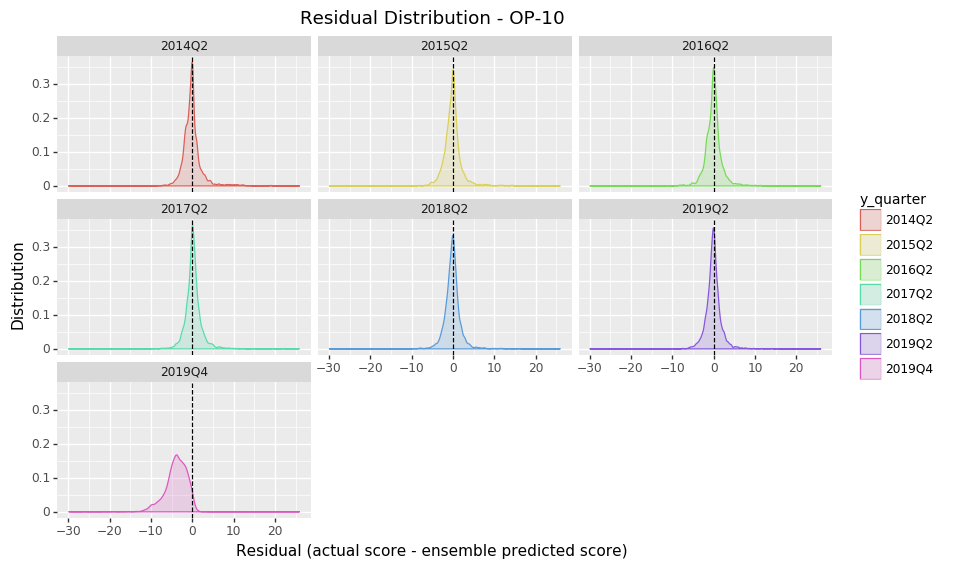

<ggplot: (8758843500521)>

In [49]:
plotnine.options.figure_size = (10,6)
(ggplot(diff_dataset,
        aes(x = 'diff', fill = 'y_quarter', color = 'y_quarter'))
 + ggtitle("Residual Distribution - OP-10")
 + geom_density(alpha = 0.2)
 + xlab("Residual (actual score - ensemble predicted score)")
 + ylab("Distribution")
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + theme(legend_title = element_text(size = 10))
 + facet_wrap('~y_quarter')
)

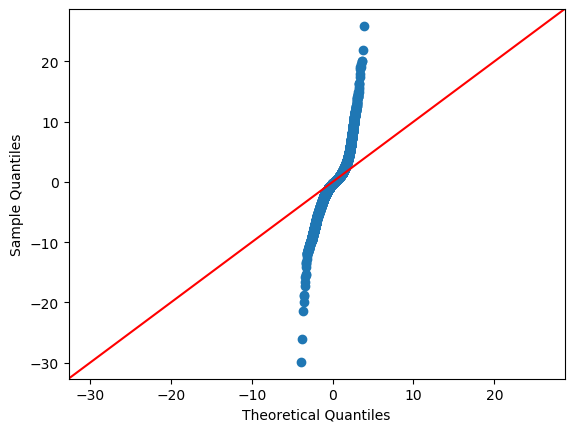

In [50]:
plotnine.options.figure_size = (10,6)
statsm.qqplot(diff_dataset['diff'], line ='45')
py.show()

In [51]:
ensemble_op10_dataset[['y_quarter', 'score']].groupby('y_quarter').describe()

score                                                  
            count       mean        std  min  25%   50%   75%   max
y_quarter                                                          
2014Q2     3531.0  10.201303  11.622132  0.1  3.4  6.30  11.6  92.0
2015Q2     3527.0   9.079671  10.138090  0.1  3.3  5.80  10.5  82.6
2016Q2     3560.0   8.104382   8.251976  0.1  3.3  5.65   9.7  82.9
2017Q2     3598.0   7.851167   7.371403  0.1  3.5  6.00   9.6  81.4
2018Q2     3678.0   7.193556   7.116813  0.1  3.3  5.50   8.7  80.3
2019Q2     3800.0   6.686395   6.325203  0.1  3.1  5.20   8.2  82.7
2019Q4     3105.0   2.203800   2.164574  0.1  1.0  1.70   2.8  41.5

In [52]:
diff_dataset[['y_quarter', 'diff']].groupby('y_quarter').describe()

diff                                                     \
            count      mean       std        min       25%       50%   
y_quarter                                                              
2014Q2     3531.0 -0.033858  2.372206  -8.314670 -1.236493 -0.180550   
2015Q2     3527.0 -0.069386  2.192272 -11.380823 -1.127031 -0.109148   
2016Q2     3560.0 -0.022585  1.983392 -11.386736 -0.995851 -0.032803   
2017Q2     3598.0  0.260007  2.038201  -9.711828 -0.678783  0.129032   
2018Q2     3678.0 -0.090958  1.946241  -9.504679 -1.026637 -0.106067   
2019Q2     3800.0 -0.036073  1.859598  -9.895397 -0.929993 -0.072674   
2019Q4     3105.0 -3.903973  2.688132 -29.887934 -5.261328 -3.649872   

                                
                75%        max  
y_quarter                       
2014Q2     0.578352  20.044823  
2015Q2     0.675594  20.112282  
2016Q2     0.768951  16.502090  
2017Q2     0.992655  25.904722  
2018Q2     0.703952  16.197327  
2019Q2     0.736951  15.404970  
2019Q4    -2.009589   3.218788